In [97]:
import os
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, RGCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from rdkit import Chem
from rdkit.Chem import AllChem

from utils.constants import HOME_DIR, DATA_DIR

# Data Preparation

In [98]:
data_path = DATA_DIR + 'clean_data.csv'
data = pd.read_csv(data_path)

x = data['Canonical_QSARr']
y = data['LD50_mgkg'].to_numpy()
y = np.log(y)
y = list(y)

print('length of x:', len(x))
print('sample of x:', x[0])
print('====================')

print('length of y:', len(y))
print('sample of y:', y[0])

length of x: 5306
sample of x: [O-][N+](=O)C1C=CC(Cl)=CC=1
length of y: 5306
sample of y: 6.131226489483141


In [99]:
def smiles_to_graph(smiles_list, labels):
    """
    Converts a list of SMILES strings into a list of PyTorch Geometric Data objects,
    including bond types as edge attributes.
    """
    def get_atom_hash(atomic_number):
        """ 
        A helper function to quickly encode atomic number into a one-hot vector
        """
        atomic_number_list = [1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 34, 35, 53] # Atomic numbers of atoms in the dataset (length 13)
        if atomic_number in atomic_number_list:
            return atomic_number_list.index(atomic_number)
        else:
            raise ValueError(f'Atomic number {atomic_number} not supported')

    def get_bond_type(bond):
        """
        Encodes bond type as an integer:
        - Single: 0
        - Double: 1
        - Triple: 2
        - Aromatic: 3
        """
        bond_type = bond.GetBondType()
        if bond_type == Chem.rdchem.BondType.SINGLE:
            return 0
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            return 1
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            return 2
        elif bond_type == Chem.rdchem.BondType.AROMATIC:
            return 3
        else:
            raise ValueError(f'Unsupported bond type: {bond_type}')

    data_list = []
    for smiles, label in zip(smiles_list, labels):
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)  # Add explicit hydrogens to the molecule
        if mol is None:
            raise ValueError(f'Could not parse SMILES string: {smiles}')

        # Node features: One-hot vector depending on the atomic number (the position of the 1 in the vector)
        node_features = []
        for atom in mol.GetAtoms():
            atomic_number = atom.GetAtomicNum()
            one_hot = [0] * len([1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 34, 35, 53]) # Length of the atomic number list
            one_hot[get_atom_hash(atomic_number)] = 1
            node_features.append(one_hot)

        x = torch.tensor(node_features, dtype=torch.float)

        # Edge indices and edge types (bond types)
        edge_indices = []
        edge_types = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            
            # Add edges (both directions for undirected graph)
            edge_indices.append((i, j))
            edge_indices.append((j, i))
            
            # Add bond type for both directions
            bond_type = get_bond_type(bond)
            edge_types.append(bond_type)
            edge_types.append(bond_type)

        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_type = torch.tensor(edge_types, dtype=torch.long)

        # Target value (LD50 label)
        y = torch.tensor([label], dtype=torch.float)

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_type=edge_type, y=y)
        data_list.append(data)

    return data_list

In [100]:
# Convert to PyTorch Geometric Data objects
data_list = smiles_to_graph(x, y)

# Create DataLoader for batching (test, train, val split)
test_size = int(len(data_list) * 0.1)
val_size = int(len(data_list) * 0.1)
train_size = len(data_list) - test_size - val_size

# Set random seed for reproducibility
torch.manual_seed(0)
train_data, val_data, test_data = torch.utils.data.random_split(data_list, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model

In [101]:
class GCNRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, 128)  # First GCN layer
        self.conv2 = GCNConv(128, 64)         # Second GCN layer
        self.conv3 = GCNConv(64, 64)         # Third GCN layer
        self.conv4 = GCNConv(64, 32)         # Fourth GCN layer
        self.fc = nn.Linear(32, 1)          # Fully connected layer for regression

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply GCN layers with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)

        # Global mean pooling to aggregate node features for each graph
        x = global_mean_pool(x, batch)

        # Fully connected layer for regression output
        out = self.fc(x)
        return out
    

class RGCNRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, num_edge_types):
        super().__init__()
        self.conv1 = RGCNConv(input_dim, 256, num_relations=num_edge_types)
        self.conv2 = RGCNConv(256, 256, num_relations=num_edge_types)
        self.conv3 = RGCNConv(256, 32, num_relations=num_edge_types)
        self.fc = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index, edge_type, batch = data.x, data.edge_index, data.edge_type, data.batch

        # Apply RGCN layers with ReLU activation
        x = self.conv1(x, edge_index=edge_index, edge_type=edge_type)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index=edge_index, edge_type=edge_type)
        x = F.relu(x)

        x = self.conv3(x, edge_index=edge_index, edge_type=edge_type)
        x = F.relu(x)
        
        # Global mean pooling to aggregate node features for each graph
        x = global_mean_pool(x, batch)

        # Fully connected layer for regression output
        out = self.fc(x)
        
        return out

# Training

In [102]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RGCNRegressionModel(input_dim=13, num_edge_types=4).to(device)  # Adjust input_dim based on node features
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

# Training loop with eval on validation set
# Train with R2 regularization
for epoch in range(200):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out = model(batch)

        loss = criterion(out.squeeze(), batch.y)

        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_loader)
    train_losses.append(total_loss)

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out.squeeze(), batch.y)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Epoch 1, Train Loss: 5.0749, Val Loss: 3.8813
Epoch 21, Train Loss: 2.3379, Val Loss: 2.9588
Epoch 41, Train Loss: 1.8737, Val Loss: 2.4960
Epoch 61, Train Loss: 1.4752, Val Loss: 2.2544
Epoch 81, Train Loss: 1.2423, Val Loss: 2.3470
Epoch 101, Train Loss: 1.0508, Val Loss: 2.2941
Epoch 121, Train Loss: 0.8896, Val Loss: 2.3556
Epoch 141, Train Loss: 0.8066, Val Loss: 2.5745
Epoch 161, Train Loss: 0.7229, Val Loss: 2.3475


KeyboardInterrupt: 

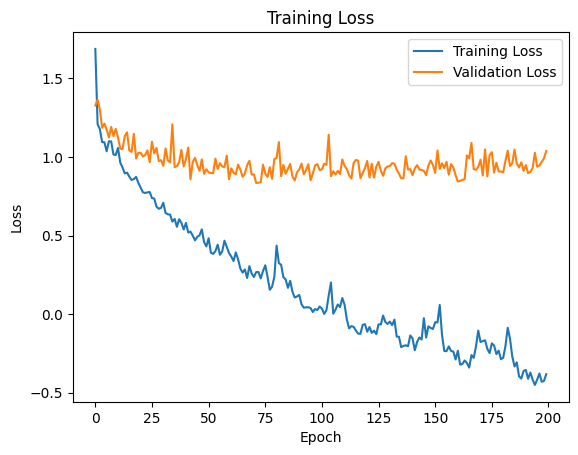

In [92]:
# log plot of loss
plt.plot(np.log(train_losses), label='Training Loss')
plt.plot(np.log(val_losses), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [93]:
# Validation loop
model.eval()
total_loss = 0

y_true = np.array([])
y_pred = np.array([])

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        out = model(batch)
        loss = criterion(out.squeeze(), batch.y)
        total_loss += loss.item()

        y_true = np.concatenate([y_true, batch.y.cpu().numpy()])
        y_pred = np.concatenate([y_pred, out.cpu().numpy().squeeze()])


print(f"Validation Loss: {total_loss:.4f}")


Validation Loss: 25.4201


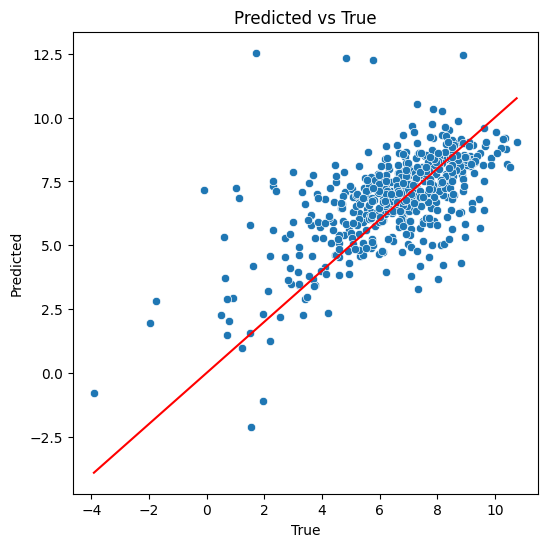

In [94]:
# Plot predicted vs true values
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred)
# Add a line
x_plot = np.linspace(min(y_true), max(y_true), 100)
plt.plot(x_plot, x_plot, color='r')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Predicted vs True')
plt.show()